<a href="https://colab.research.google.com/github/cgpilapanta/timeseries/blob/main/TEG_Cap_03_EC01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CAPÍTULO 03. ANÁLISE TEMPORAL**
---
*   Autor: Christian G. Pilapanta A.
*   Data : Outubro de 2024
*   Lotação: Departamento de Geomática - UFPR / Laboratorio de Geodésia Espacial e Hidrografia

---

**Definição do entorno de trabalho e Importação de dados**

In [ ]:
#Bibliotecas de Python necessárias para rodar o código
#%pip install ruptures
#import ruptures as rpt

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u

from scipy.signal import detrend
from scipy.stats import levene
from statsmodels.formula.api import ols
from astropy.timeseries import LombScargle
from pandas.plotting import autocorrelation_plot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Eliminar alertas por versão
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [ ]:
# Importar (clonar) repósitorio de GitHub
!rm -r timeseries
!git clone https://github.com/cgpilapanta/timeseries.git

Cloning into 'timeseries'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 280 (delta 9), reused 0 (delta 0), pack-reused 254 (from 1)
Receiving objects: 100% (280/280), 35.21 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (110/110), done.


## Exercício 01. Série de coordenadas GPS. Modelo linear de trajetórias
---

A definição fundamental do Sistema de Referência Terrestre Internacional, ITRS (em inglês: International Terrestrial Reference System) se baseia na materialização de um conjunto de pontos sobre a superfície terrestre, cujas coordenadas são definidas convencionalmente para uma época de referência em particular. Isto inclui suas variações lineares no tempo.

Desta maneira, a parte secular do poliedro mundial é basicamente determinada por um conjunto de coordenadas ${ \overrightarrow { X }  }_{ 0 }^{ \left( i \right)  }$ e velocidades ${ \overrightarrow { V }  }_{ 0 }^{ \left( i \right)  }$, $\forall i\in N:i\le 1$, relacionadas através do estabelecimento de um modelo funcional linear, chamado de ''modelo linear de trajetórias'' (em inglês: standard linear trajectory model, SLTM):

\begin{equation}
{ \overrightarrow { X }  }^{ \left( i \right)  }\left( t \right) ={ \overrightarrow { X }  }_{ 0 }^{ \left( i \right)  }+{ \overrightarrow { V }  }_{ 0 }^{ \left( i \right)  }\left( t-{ t }_{ 0 } \right)
\end{equation}

onde, ${ t }_{ 0 }$ é a época de referência.

O poliedro define de forma implícita os eixos, a origem e a escala do sistema de coordenadas, o mesmo que serve como base para a descrição do estado geométrico da Terra e dos processos físicos ocorrentes na sua superfície e no seu interior.

Dependendo do período de tempo analisado, é possível incluir na equação um termo que represente as flutuações de curto período dos pontos advinda dos diferentes processos geofísicos. Desta maneira o SLTM pode ser representado por:

\begin{equation}
{ \overrightarrow { X }  }\left( t \right) ={ \overrightarrow { X }  }\left( { t }_{ 0 } \right) +{ \overrightarrow { V }  }_{ 0 }^{ \left( i \right)  }\left( t-{ t }_{ 0 } \right) +\sum _{ k=1 }^{ K }{ { \overrightarrow { g }  }_{ k } } \left( t \right)
\end{equation}

onde, o termo ${ \overrightarrow { g }  }_{ k }\left( t \right) $, representa os deslocamentos dos pontos obtidos com base na utilização dos modelos a-priori definidos na IERS Conventions 2010.

<center><img src=https://iili.io/dV2O3sS.md.png width="520"></center>

**Importante:**

No ano 2007, o IERS, através de sua Agência Especial do GGFC (em inglês: GGFC Special Bureau for Loading) concluiu que o SLTM não é uma abordagem adequada para satisfazer o nível de acurácia estabelecido pelo GGOS de $10^{-9}$ ou melhor. Isto, devido a que este não é capaz de modelar de forma consistente as variações na forma da Terra, no campo de gravidade e na rotação terrestre, de forma integrada e correlacionada.

### A. Importar o conjunto de dados

In [ ]:
# Definir nomes de cada coluna
header = ['Date','Time','Year','MJD','East','North','Up']

# Importar arquivo de texto (dataframe Pandas)
df_gps = pd.read_csv("/content/timeseries/datasets/lageh/GPS/NGL_ENU.NAUS_DLY.txt", names=header, delim_whitespace=True)

# Criar dataframe só com a componente Este
df_east = df_gps[['Year','East']].copy()

# Apresentar tabela de dados
df_gps.head()

,Date,Time,Year,MJD,East,North,Up
0,2006-01-01,12:00:00,2006.001370,53736.5,30.212963,-79.047382,13.418281
1,2006-01-02,12:00:00,2006.004110,53737.5,25.439944,-81.108322,4.016594
2,2006-01-03,12:00:00,2006.006849,53738.5,24.674618,-80.279320,9.996804
3,2006-01-04,12:00:00,2006.009589,53739.5,26.697969,-81.431313,2.156331
4,2006-01-05,12:00:00,2006.012329,53740.5,25.279543,-78.320914,11.315283


### B. Plotar o conjunto de dados

In [ ]:
# Ativar "plotly" para geração de gráficos interativos
pd.options.plotting.backend = "plotly"

# Geração da série de coordenadas
fig = df_gps.plot(title = "UFPR Continuous Monitoring GNSS Station. East Component", x = 'Year', y = 'East')

# Apresentar série de tempo
fig.show()

### C. Análise do modelo de Gauss-Markov

#### C.1. Análise da normalidade dos dados

Text(0.5, 1.0, "Histogram with 'auto' bins")

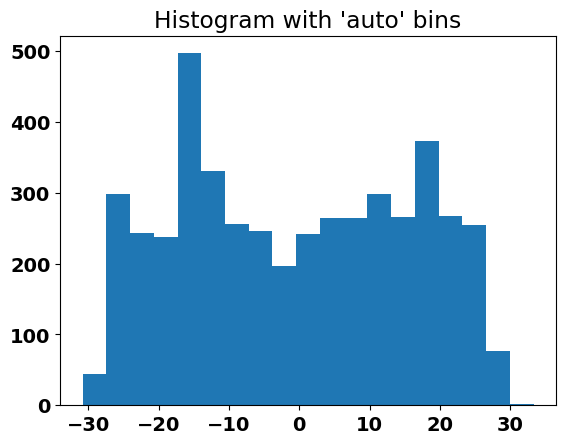

In [ ]:
#Plotar o histograma dos dados
plt.hist(df_gps['East'], bins='auto')
plt.title("Histogram with 'auto' bins")

#### C.2. Análise das medidas de posição (média aritmética)

In [ ]:
# Cálculo da média dos dados
mean_s = np.mean(df_gps['East'])

print('média = %f' % (mean_s))

média = -0.589653


##### C.2.1. Centralizar os dados (média zero)

In [ ]:
# Geração de dados normalizados
df_gps['East_n'] = df_gps['East'] - mean_s

# Cálculo da média dos dados normalizados
mean_s_n = np.mean(df_gps['East_n'])

print('média = %f' % (mean_s_n))

média = 0.000000


#### C.3. Análise de homocedasticidade (estacionariedade e variância constante) - Dados originais

In [ ]:
# Criar modelo para teste
df_model = ols(formula='East_n~Year', data=df_gps).fit()

# Função para testar os dados
def test_model(col):
  s = []
  for i in col:
    a = [1,i]
    s.append(a)
  return (np.array(s))

# Executar modelo nos dados
comp_model = test_model(df_gps['East_n'])

# Realizar teste de hipótese
bp_test = het_breuschpagan(df_model.resid, comp_model)

# Imprimir resultados
print('LM-test p_value = %f' % bp_test[1])

LM-test p_value = 0.000000


**Interpretação:**

O resultado do *valor p* é 0, valor muito abaixo do nível de significância, portanto podemos rejeitar a $H_0$ (i.e. os dados são heterocedásticos).

#### C.4 Filtragem da tendência de longo prazo

##### C.4.1. Determinação da tendência (Função polinomial grau 1 - MMQ)

In [ ]:
# Ajuste por mínimos quadrados da função polinomial de grau 1
adjust = np.polyfit(df_gps['Year'], df_gps['East_n'], 1)

# Determinação da tendência
trend = np.polyval(adjust, df_gps['Year'])

# Valores de tendência

print('trend = %f' % (adjust[0]))
print('intercept = %f' % (adjust[1]))

trend = -3.955232
intercept = 7961.459168


Text(0.5, 1.0, 'UFPR Continuous Monitoring GNSS Station. East Component')

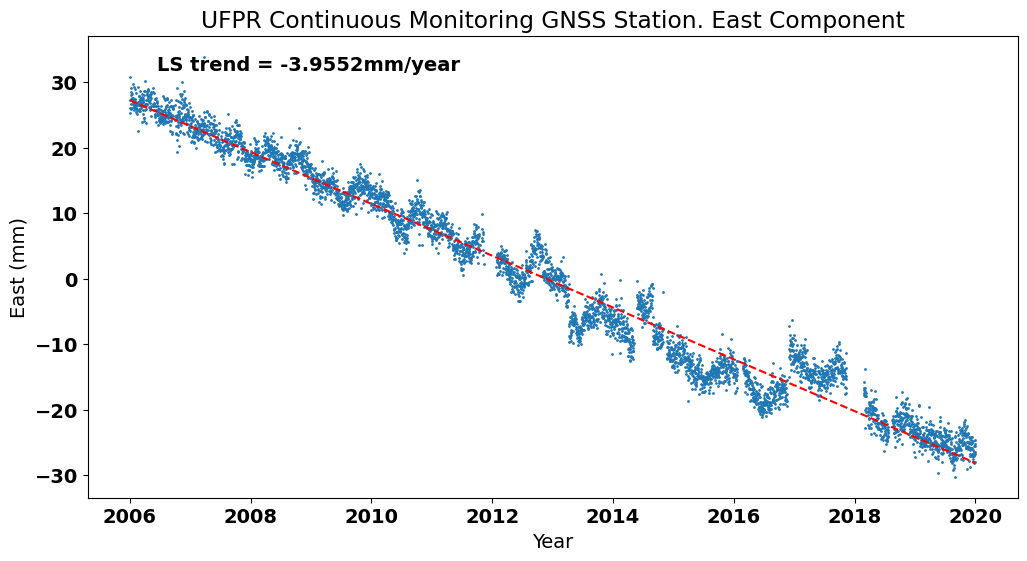

In [ ]:
# Parâmetros de figura
plt.figure(figsize=(12,6))

# Plotagem das coordenadas GPS
plt.scatter(df_gps['Year'], df_gps['East_n'], s=1)

# Plotagem da função polinomial de ajuste
plt.plot(df_gps['Year'], trend, 'r', linestyle='--')

# Parâmetros adicionais da figura
plt.text(0.4, 0.925,'LS trend = ' + str(np.round(adjust[0],4)) + 'mm/year', ha='right', transform=plt.gca().transAxes, color = 'k')
plt.ylabel("East (mm)")
plt.xlabel("Year")
plt.title("UFPR Continuous Monitoring GNSS Station. East Component")

##### C.4.2. Eliminação da tendência (High-Pass Filter)

In [ ]:
# Filtragem da tendência do conjunto de dados
df_gps['East_d'] = df_gps['East_n'] - trend

# Valores filtrados
df_gps.head()

,Date,Time,Year,MJD,East,North,Up,East_n,East_d
0,2006-01-01,12:00:00,2006.001370,53736.5,30.212963,-79.047382,13.418281,30.802616,3.544056
1,2006-01-02,12:00:00,2006.004110,53737.5,25.439944,-81.108322,4.016594,26.029597,-1.218126
2,2006-01-03,12:00:00,2006.006849,53738.5,24.674618,-80.279320,9.996804,25.264271,-1.972619
3,2006-01-04,12:00:00,2006.009589,53739.5,26.697969,-81.431313,2.156331,27.287622,0.061570
4,2006-01-05,12:00:00,2006.012329,53740.5,25.279543,-78.320914,11.315283,25.869196,-1.346019


Text(0.5, 1.0, 'UFPR Continuous Monitoring GNSS Station. East Component')

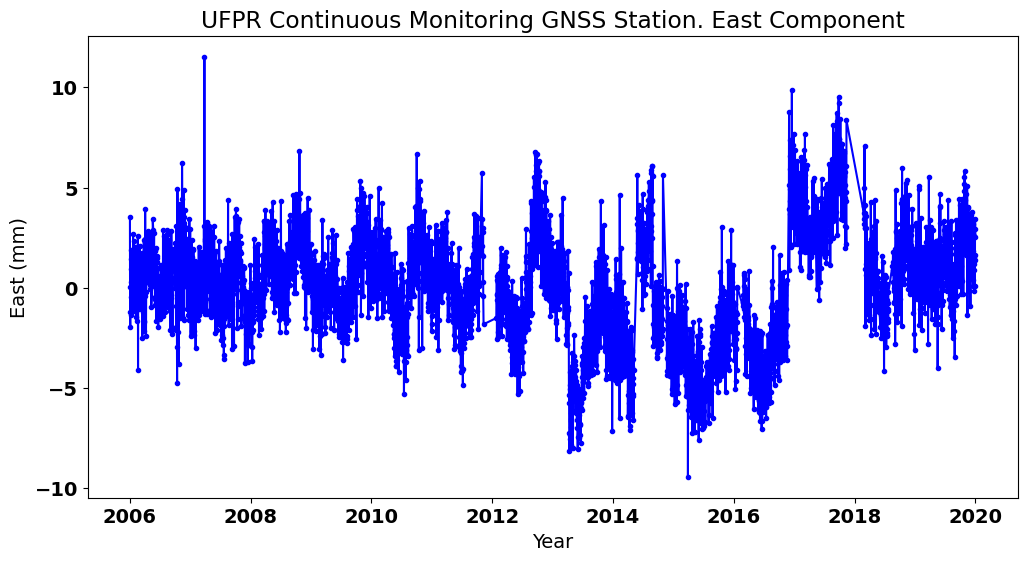

In [ ]:
# Parâmetros de figura
plt.figure(figsize=(12,6))

# Plotagem das coordenadas GPS filtradas
plt.plot(df_gps['Year'], df_gps['East_d'], label='Data Values', marker='.', linestyle='-', color='blue')

# Parâmetros adicionais da figura
plt.ylabel("East (mm)")
plt.xlabel("Year")
plt.title("UFPR Continuous Monitoring GNSS Station. East Component")

##### C.4.3 Análise da normalidade dos dados filtrados

Text(0.5, 1.0, "Histogram with 'auto' bins")

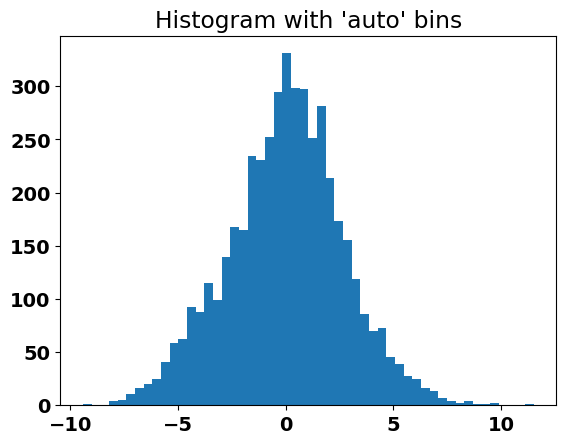

In [ ]:
#Plotar o histograma dos dados
plt.hist(df_gps['East_d'], bins='auto')
plt.title("Histogram with 'auto' bins")

#### C.5. Deteção e eliminação de outliers

##### C.5.1. Análise do diagrama de caixa (Boxplot)

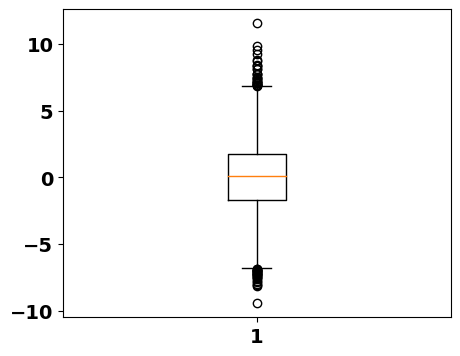

In [ ]:
# Parâmetros de figura
plt.figure(figsize=(5,4))

# Creating plot
plt.boxplot(df_gps['East_d'])

plt.show()

##### C.5.1. Cálculo do IQR

In [ ]:
# Cálculos do 1 e 3 quartil
Q1 = df_gps['East_d'].quantile(0.25)
Q3 = df_gps['East_d'].quantile(0.75)

# Cálculo do Rango interquartil
IQR = Q3 - Q1

# Límites de deteção (exemplo: 1.5 vezes o IQR)
threshold_lower = Q1 - 1.5 * IQR
threshold_upper = Q3 + 1.5 * IQR

# Identificar valores anômalos
anomalies = df_gps[(df_gps['East_d'] < threshold_lower) | (df_gps['East_d'] > threshold_upper)]

anomalies.head()

,Date,Time,Year,MJD,East,North,Up,East_n,East_d
417,2007-03-27,12:00:00,2007.234247,54186.5,33.321291,-70.573907,3.361749,33.910944,11.528698
2459,2013-04-11,12:00:00,2013.275342,56393.5,-9.328149,-20.346489,-21.498445,-8.738496,-7.226811
2460,2013-04-12,12:00:00,2013.278082,56394.5,-10.245624,-20.325112,-19.334872,-9.655971,-8.133448
2461,2013-04-13,12:00:00,2013.280822,56395.5,-9.660324,-20.357399,-17.839136,-9.070671,-7.537311
2462,2013-04-14,12:00:00,2013.283562,56396.5,-9.365871,-19.950917,-24.370105,-8.776219,-7.232021


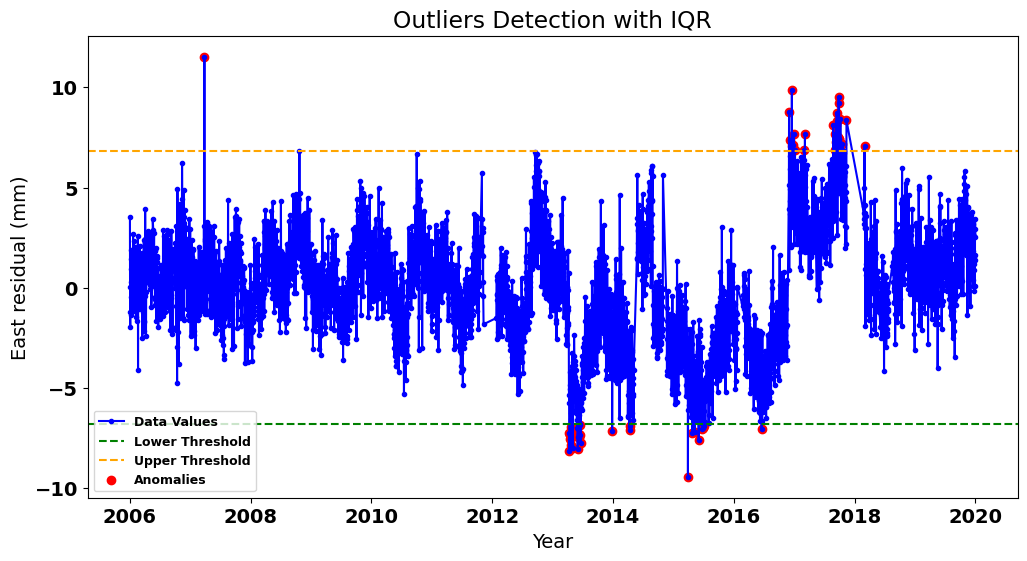

In [ ]:
# Parâmetros de figura
plt.figure(figsize=(12, 6))

# Plotagem das coordenadas
plt.plot(df_gps['Year'], df_gps['East_d'], label='Data Values', marker='.', linestyle='-', color='blue')

# Plotagem de límites (máximo e mínimo)
plt.axhline(y=threshold_lower, color='green', linestyle='--', label='Lower Threshold')
plt.axhline(y=threshold_upper, color='orange', linestyle='--', label='Upper Threshold')

# Plotagem de pontos outliers
plt.scatter(anomalies['Year'], anomalies['East_d'], color='red', label='Anomalies')

# Parâmetros adicionais da figura
plt.xlabel('Year')
plt.ylabel('East residual (mm)')
plt.title('Outliers Detection with IQR')
plt.legend(loc=3, prop={'size': 9})

##### C.5.2. Filtrar conjunto de dados

In [ ]:
# Criação de novo dataframe com outliers filtrados
df_gps_outfil = df_gps[~df_gps.isin(anomalies)].dropna()

print('número de colunas tabela original')
print(df_gps.shape)

print('número de colunas tabela de outliers')
print(anomalies.shape)

print('número de colunas tabela filtrada')
print(df_gps_outfil.shape)

número de colunas tabela original
(4658, 9)
número de colunas tabela de outliers
(58, 9)
número de colunas tabela filtrada
(4600, 9)


Text(0.5, 1.0, 'UFPR Continuous Monitoring GNSS Station. East Component')

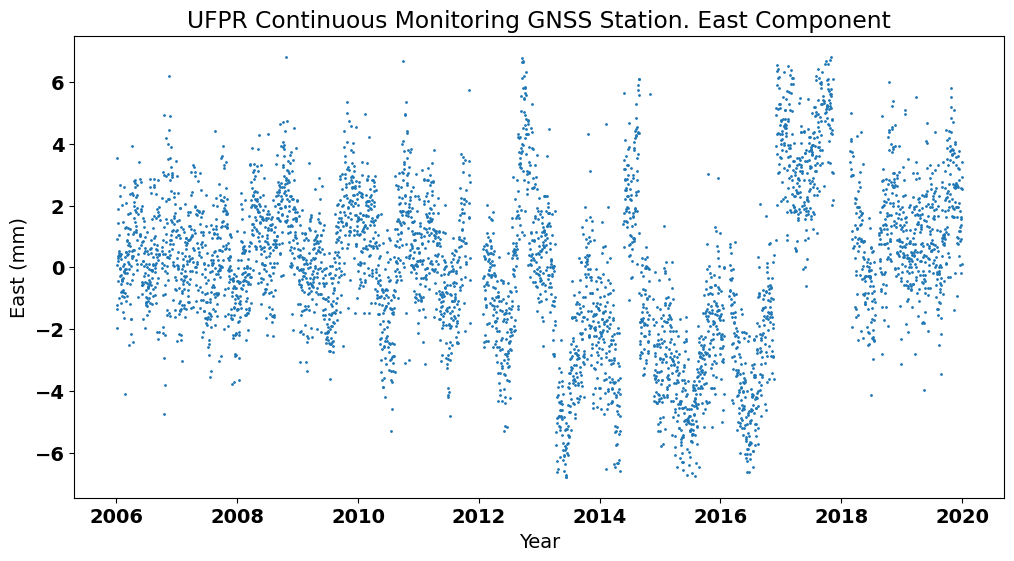

In [ ]:
# Parâmetros de figura
plt.figure(figsize=(12,6))

# Plotagem das coordenadas GPS filtradas
plt.scatter(df_gps_outfil['Year'], df_gps_outfil['East_d'], s=1)

# Parâmetros adicionais da figura
plt.ylabel("East (mm)")
plt.xlabel("Year")
plt.title("UFPR Continuous Monitoring GNSS Station. East Component")

#### C.6. Análise da periodicidade da série

##### C.6.1. Função de autocorrelação

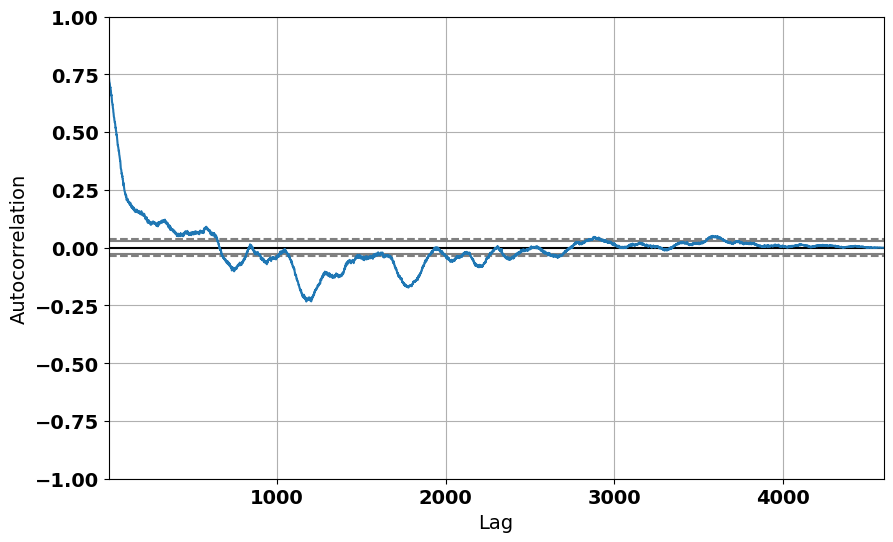

In [ ]:
# Parâmetros de figura
plt.figure(figsize=(10,6))

autocorrelation_plot(df_gps_outfil['East_d'])
plt.show()

##### C.6.2. Determinação das componentes periódicas da série

In [ ]:
def full_function(x, A, B, C):
    return (A * np.cos(2 * np.pi * x / C)) + (B * np.sin(2 * np.pi * x / C))

Fitted parameters: A=-0.4528953756607608, B=0.7891423871276172, C=1.0017688465201386


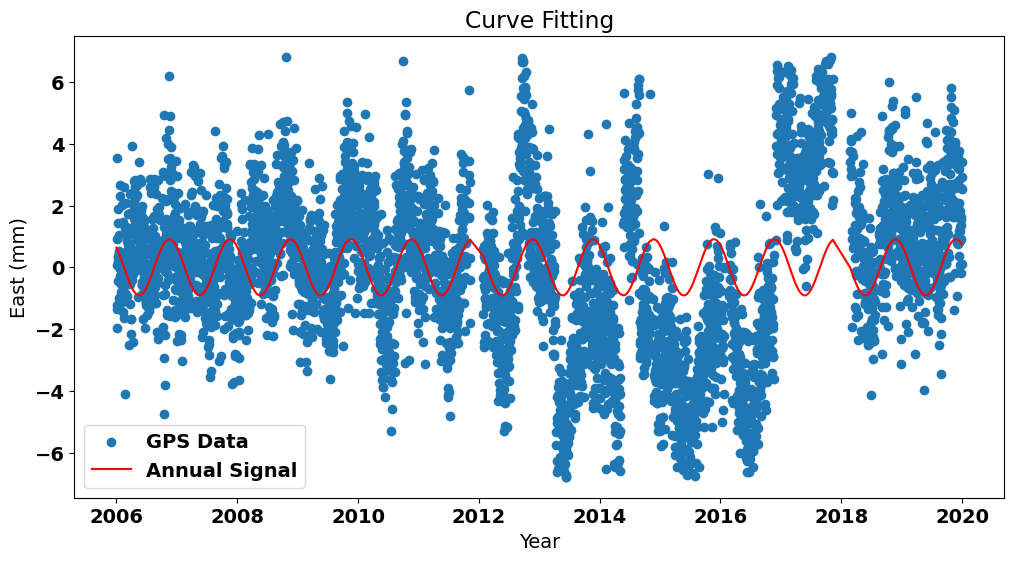

In [ ]:
from scipy.optimize import curve_fit

# Initial guess for the parameters [A, B, C]
initial_guess = [0.2, 0.8, 1]

# Perform the curve fitting
params, covariance = curve_fit(full_function, df_gps_outfil['Year'], df_gps_outfil['East_d'], p0=initial_guess, maxfev = 20000)

# Extract the fitted parameters
A_fit, B_fit, C_fit = params

print(f"Fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}")
# Generate y values using the fitted parameters
y_fit = full_function(df_gps_outfil['Year'], A_fit, B_fit, C_fit)

# Plot the original data and the fitted curve
plt.figure(figsize=(12,6))
plt.scatter(df_gps_outfil['Year'], df_gps_outfil['East_d'], label='GPS Data')
plt.plot(df_gps_outfil['Year'], y_fit, label='Annual Signal', color='red')
plt.ylabel('East (mm)')
plt.xlabel('Year')
plt.title('Curve Fitting')
plt.legend()
plt.show()

##### C.6.3. Análise harmônico da série (exemplo)

In [ ]:
# intervalo do sinal (anual)
yr = 1

# cálculo da frequência do sinal
f = 1 / float(365.25 * yr)

# cálculo do periodo do sinal
T = float(len(df_gps_outfil['East_d']))

# wavenumber
k = f * T
print("The wavenumber is",k)

# Indexador de tempo
time = np.arange(0,len(df_gps_outfil['East_d']))

# Argumento para as funções seno e cosseno
theta = 2*np.pi*time*f

The wavenumber is 12.594113620807665


In [ ]:
# Cálculo das componentes seno e cosseno para la frequência dada
coskd = np.cos(theta)
sinkd = np.sin(theta)

# Cálculo dos coeficientes dos harmônicos
ak = 2*np.mean(coskd * df_gps_outfil['East_d'])
bk = 2*np.mean(sinkd * df_gps_outfil['East_d'])

# Transformação à amplitude e fases
ck = np.sqrt(ak**2 + bk**2)
lk = np.arctan2(bk,ak)/k

# Determinação do sinal final
annual_signal = ck*np.cos(theta - lk)

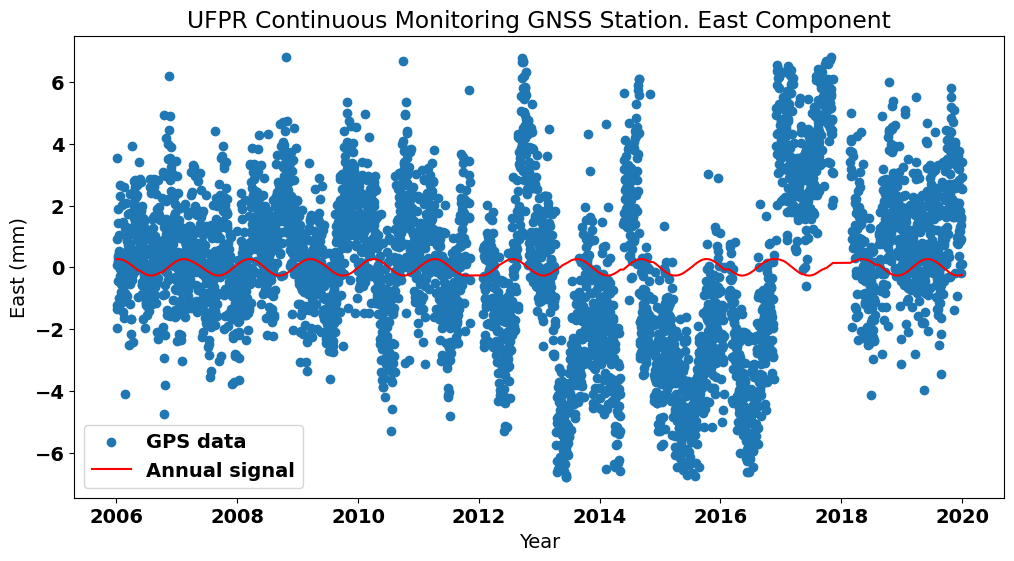

In [ ]:
# Parâmetros de figura
plt.figure(figsize=(12,6))

# Plotagem das coordenadas GPS filtradas e do sinal anual
plt.scatter(df_gps_outfil['Year'], df_gps_outfil['East_d'], label='GPS data')
plt.plot(df_gps_outfil['Year'], annual_signal, label='Annual signal', color='red')

# Parâmetros adicionais da figura
plt.ylabel("East (mm)")
plt.xlabel("Year")
plt.title("UFPR Continuous Monitoring GNSS Station. East Component")
plt.legend()
plt.show()

#### C.7. Deteção de saltos na série

##### C.7.1. Deteção usando Dynp algorithm (dynamic programming)

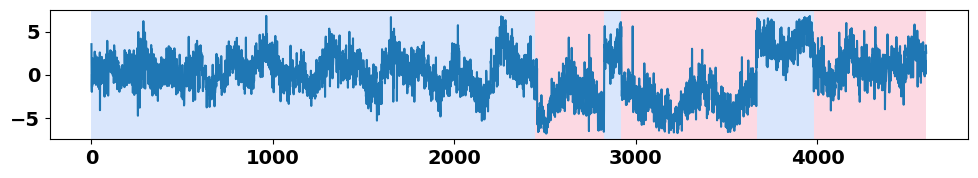

In [ ]:
east_reshape = df_gps_outfil['East_d'].values.reshape(-1, 1)

# change point detection
model = "l1"  # "l2", "rbf"
change_points = rpt.Dynp(model=model, min_size=3, jump=5).fit(east_reshape)
my_bkps = change_points.predict(n_bkps=5)

# show results
rpt.show.display(east_reshape, my_bkps)
plt.show()

In [ ]:
print(my_bkps)

[2445, 2825, 2920, 3665, 3980, 4600]
